In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Setup environment

In [2]:
# Verifica e instala MONAI, matplotlib y torch si es necesario
!python -c "import monai" || pip install -q "monai[all]"  # Instala la versión completa de MONAI, que incluye dependencias
!python -c "import torch" || pip install -q torch         # Verifica si torch está instalado, e instálalo si no lo está
!python -c "import matplotlib" || pip install -q matplotlib

%matplotlib inline

2024-12-18 17:03:42.240859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734541422.260231  158887 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734541422.266276  158887 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import monai
print(dir(monai.networks.nets))
print(monai.__version__)

/mnt/nfs/home/liglesias/anaconda3/envs/cardio/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-18 17:03:57.900122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734541437.919835  158873 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734541437.925650  158873 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['AHNet', 'AHnet', 'Ahnet', 'AttentionUnet', 'AutoEncoder', 'AutoencoderKL', 'BasicUNet', 'BasicUNetPlusPlus', 'BasicUnet', 'BasicUnetPlusPlus', 'Basicunet', 'BasicunetPlusPlus', 'BertAttention', 'BertMixedLayer', 'BertOutput', 'BertPreTrainedModel', 'BlockArgs', 'Classifier', 'ControlNet', 'Critic', 'DAF3D', 'DecoderOnlyTransformer', 'DenseNet', 'DenseNet121', 'DenseNet169', 'DenseNet201', 'DenseNet264', 'Densenet', 'Densenet121', 'Densenet169', 'Densenet201', 'Densenet264', 'DiNTS', 'DiffusionModelUNet', 'Discriminator', 'DynUNet', 'DynUnet', 'Dynunet', 'EfficientNet', 'EfficientNetBN', 'EfficientNetBNFeatures', 'EfficientNetEncoder', 'FLEXUNET_BACKBONE', 'FlexUNet', 'FlexUNetEncoderRegister', 'FlexibleUNet', 'FullyConnectedNet', 'Generator', 'GlobalNet', 'HighResBlock', 'HighResNet', 'HoVerNet', 'HoVernet', 'HoverNet', 'Hovernet', 'LocalNet', 'MILModel', 'MedNeXt', 'MedNeXtB', 'MedNeXtL', 'MedNeXtLarge', 'MedNeXtM', 'MedNeXtMedium', 'MedNeXtS', 'MedNeXtSmall', 'MedNext', 'MedNextB',

## Setup imports

In [4]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import nibabel as nib
from nibabel.orientations import axcodes2ornt, ornt_transform
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import Dataset, DataLoader
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged
#from torch.amp import autocast
#from torch.cuda.amp import autocast
from torch.amp import autocast
from monai.networks.nets import AutoencoderKL, PatchDiscriminator
# from generative.networks.nets import AutoencoderKL, PatchDiscriminator
from monai.losses import PatchAdversarialLoss, PerceptualLoss
from monai.utils.misc import ensure_tuple
print_config()

MONAI version: 1.5.dev2447
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 2d6751b01bf78fddabe03b2c53645c6bc9808ed8
MONAI __file__: /mnt/nfs/home/<username>/anaconda3/envs/cardio/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.1
lmdb version: 1.5.1
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.18.0
pynrrd version: 1.1.1
clearml version: 1.16.5

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [77]:
#root_dir = r"C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database"
#root_dir = '/mnt/nfs/home/liglesias/data_tgv'
#root_dir = '//atlas.bit.upm.es/BIT-UPM-projects/CARDIO-HULP/SCRATCH_STUDENTS/liglesias/data_acdc'

root_dir = '/mnt/nfs/home/liglesias/data_acdc'

training_dir = os.path.join(root_dir, "masks_training")
testing_dir = os.path.join(root_dir, "masks_testing")
training_dir_noise = os.path.join(root_dir, "masks_training_noise")
testing_dir_noise = os.path.join(root_dir, "masks_testing_noise")
training_dir_elongated = os.path.join(root_dir, "masks_training_noise_2")
testing_dir_elongated = os.path.join(root_dir, "masks_testing_noise_2")

assert os.path.exists(training_dir), f"El directorio {training_dir} no existe"
assert os.path.exists(testing_dir), f"El directorio {testing_dir} no existe"
assert os.path.exists(training_dir_noise), f"El directorio {training_dir_noise} no existe"
assert os.path.exists(testing_dir_noise), f"El directorio {testing_dir_noise} no existe"
assert os.path.exists(training_dir_elongated), f"El directorio {training_dir_elongated} no existe"
assert os.path.exists(testing_dir_elongated), f"El directorio {testing_dir_elongated} no existe"

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)
training_files_noise = list_nifti_files(training_dir_noise)
testing_files_noise = list_nifti_files(testing_dir_noise)
training_files_elongated = list_nifti_files(training_dir_elongated)
testing_files_elongated = list_nifti_files(testing_dir_elongated)

print(f"Se encontraron {len(training_files)} archivos en {training_dir}")
print(f"Se encontraron {len(testing_files)} archivos en {testing_dir}")
print(f"Se encontraron {len(training_files_noise)} archivos en {training_files_noise}")
print(f"Se encontraron {len(testing_files_noise)} archivos en {testing_dir_noise}")
print(f"Se encontraron {len(training_files_noise)} archivos en {training_files_elongated}")
print(f"Se encontraron {len(testing_files_noise)} archivos en {testing_files_elongated}")

Se encontraron 200 archivos en /mnt/nfs/home/liglesias/data_acdc/masks_training
Se encontraron 100 archivos en /mnt/nfs/home/liglesias/data_acdc/masks_testing
Se encontraron 200 archivos en ['/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient001_frame12_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame12_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient003_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient004_frame15_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame13_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient006_frame16_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient007_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/d

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 256, 10)
(232, 256, 10)


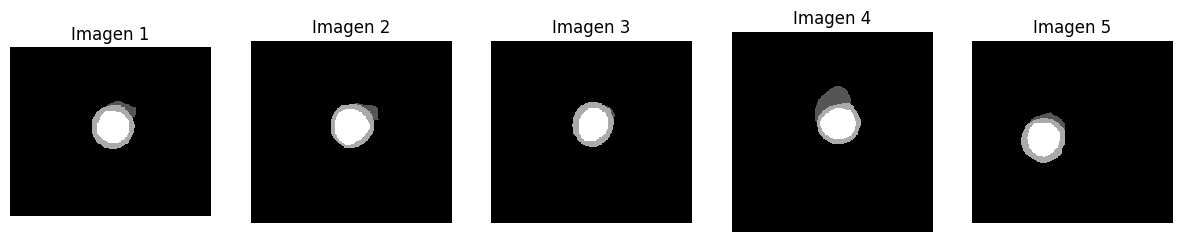

In [78]:
images = [nib.load(file).get_fdata() for file in training_files[:5]] 
fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

for i, img in enumerate(images):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 256, 10)
(232, 256, 10)


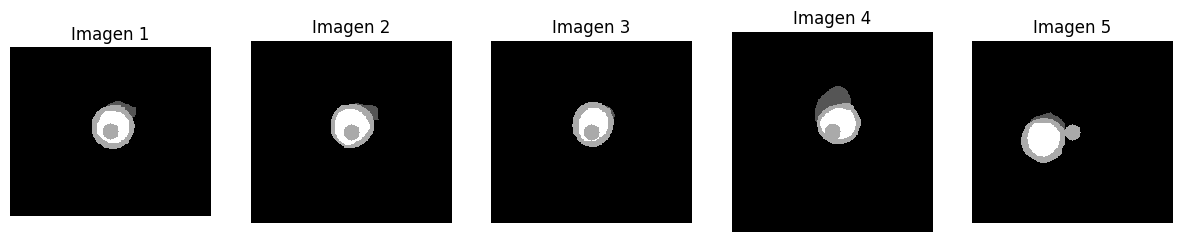

In [79]:
images_noise = [nib.load(file).get_fdata() for file in training_files_noise[:5]] 
fig, axs = plt.subplots(1, len(images_noise), figsize=(15, 5))

for i, img in enumerate(images_noise):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

In [80]:
all_files = training_files + testing_files
all_files_noise = training_files_noise + testing_files_noise

images = [nib.load(file).get_fdata() for file in all_files]
images_noise = [nib.load(file).get_fdata() for file in all_files_noise]
image_shapes = [img.shape for img in images]
image_shapes_noise = [img.shape for img in images_noise]
print(image_shapes)
print(image_shapes_noise)
average_shape = np.mean(image_shapes, axis=0).astype(int)
average_shape_noise = np.mean(image_shapes_noise, axis=0).astype(int)
print(f"Tamaño promedio: {average_shape}")
print(f"Tamaño promedio de las imágenes con ruido: {average_shape_noise}")
min_shape = np.min(image_shapes, axis=0)
max_shape = np.max(image_shapes, axis=0)
min_shape_noise = np.min(image_shapes_noise, axis=0)
max_shape_noise = np.max(image_shapes_noise, axis=0)

print(f"Tamaño mínimo: {min_shape}")
print(f"Tamaño máximo: {max_shape}")
print(f"Tamaño mínimo: {min_shape_noise}")
print(f"Tamaño máximo: {max_shape_noise}")

[(216, 256, 10), (232, 256, 10), (232, 256, 10), (256, 256, 10), (232, 256, 10), (256, 216, 10), (256, 216, 10), (232, 256, 11), (222, 224, 10), (222, 224, 10), (200, 256, 10), (208, 256, 10), (208, 256, 10), (184, 256, 10), (184, 256, 10), (216, 256, 10), (256, 216, 10), (256, 216, 10), (256, 216, 9), (216, 256, 9), (216, 256, 8), (208, 256, 8), (200, 256, 7), (200, 256, 7), (216, 256, 9), (216, 256, 9), (208, 256, 8), (208, 256, 8), (256, 256, 9), (216, 256, 10), (216, 256, 10), (224, 256, 10), (216, 256, 10), (216, 256, 10), (216, 256, 10), (240, 256, 10), (216, 256, 10), (216, 256, 10), (224, 256, 10), (208, 256, 13), (216, 256, 8), (216, 256, 7), (276, 384, 8), (276, 384, 8), (208, 256, 9), (208, 256, 10), (154, 224, 6), (232, 256, 9), (208, 256, 8), (208, 256, 8), (256, 216, 9), (256, 208, 9), (256, 208, 9), (256, 216, 7), (224, 256, 10), (216, 256, 8), (216, 256, 7), (428, 512, 8), (216, 256, 9), (216, 256, 9), (256, 216, 9), (216, 256, 9), (216, 256, 9), (256, 216, 10), (210, 2

## Set deterministic training for reproducibility

In [81]:
# for reproducibility purposes set a seed
set_determinism(42)

## Description of data, download the training set and creation of dataloaders

The brain tumour segmentation dataset is available as part of the Decathlon dataset. Select the channel (MRI contrast) you wish to use for training (0: FLAIR, 1: T1, 2: T1-PC, 3: T2). 
Note: The DecatholonDataset has 7GB. So make sure that you have enought space when running the next line

We use the following transforms:
1. `LoadImaged`: retrieve the nii image
2. `EnsureChannelFirstd`: we ensure that the channel component is in dimension 0 of the tensor
3. `Lambdad`: this custom transform retrieves the specific channel that we desire
4. `EnsureChannelFirstd`: we add the new channel dimension (as the last transform has removed it)

In [82]:
from monai.data import NibabelReader
from monai.transforms import CastToTyped

In [83]:
# PREPARACIÓN DE LA IMAGEN MÉDICA
# Carga las imágenes y se asegura de que la imagen cargada tenga el canal de color en la primera dimensión
# Aplica una transformación personalizada a la imagen y garantiza que la imagen tenga el canal en la primera dimensión
# Asegura que tenga el tipo de datos adecuado, reorienta la imagen a un sist de coord específico
# Recorta la imagen a un tamaño específico y escala la intensidad de la imagen

resize_dim = (12, 128, 128)

all_transforms = [
    transforms.LoadImaged(keys=["image"]),
    transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    transforms.EnsureTyped(keys=["image"]),
    transforms.Orientationd(keys=["image"], axcodes="LPS"),
    # transforms.Orientationd(keys=["image"], axcodes="RAS"),
    transforms.Transposed(keys=["image"], indices=(0, 3, 2, 1)),
    transforms.AsDiscreted(keys=["image"], to_onehot=4),
    transforms.Resized(keys=["image"], spatial_size=resize_dim, mode=('nearest-exact')), 
]

In [84]:
train_data_dicts = [{"image": file} for file in training_files][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts)[0]['image'].shape

torch.Size([4, 12, 128, 128])

In [85]:
train_data_dicts_noise = [{"image": file} for file in training_files_noise][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts_noise)[0]['image'].shape

torch.Size([4, 12, 128, 128])

In [86]:
train_data_dicts_elongated = [{"image": file} for file in training_files_elongated][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts_elongated)[0]['image'].shape

torch.Size([4, 12, 128, 128])

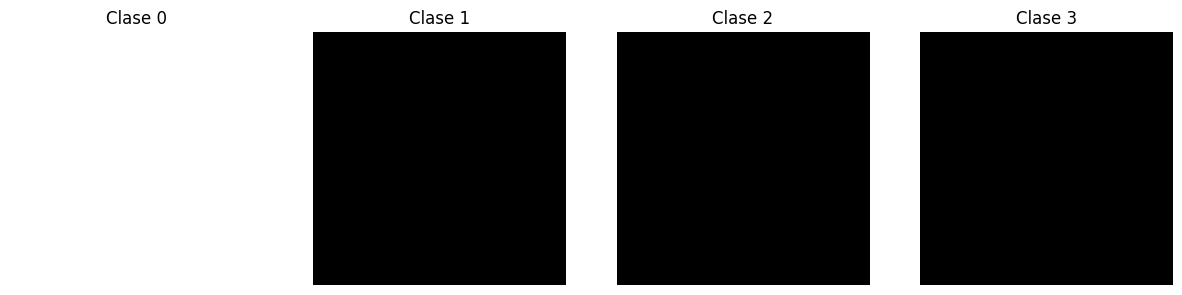

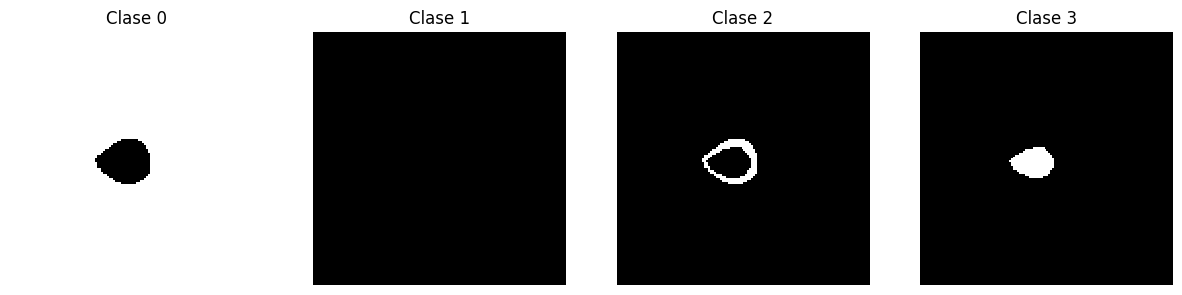

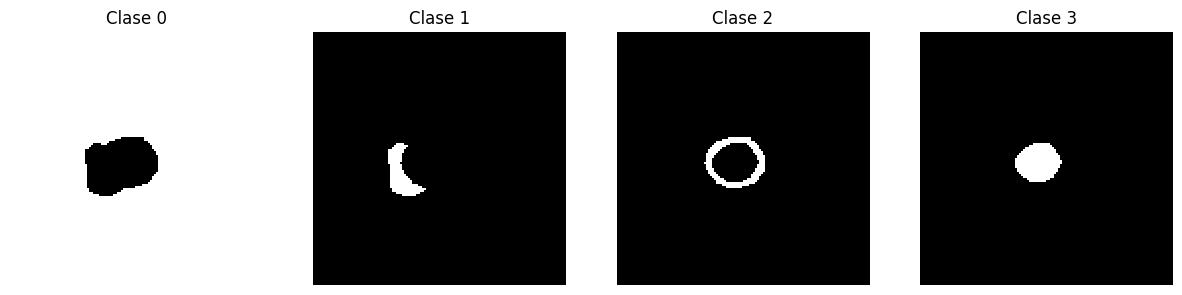

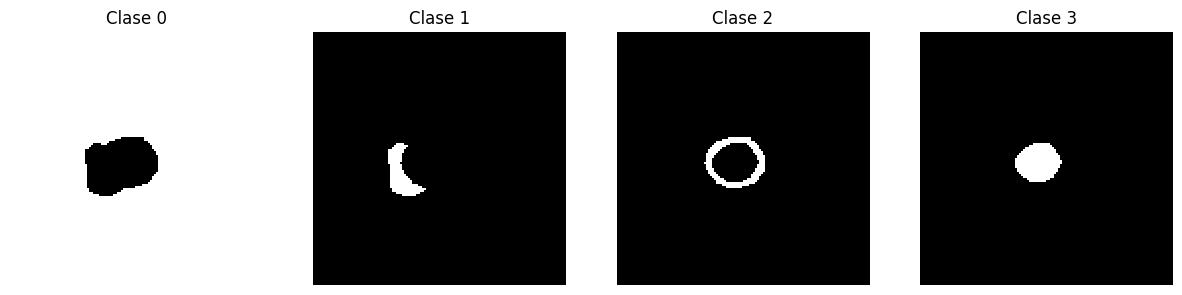

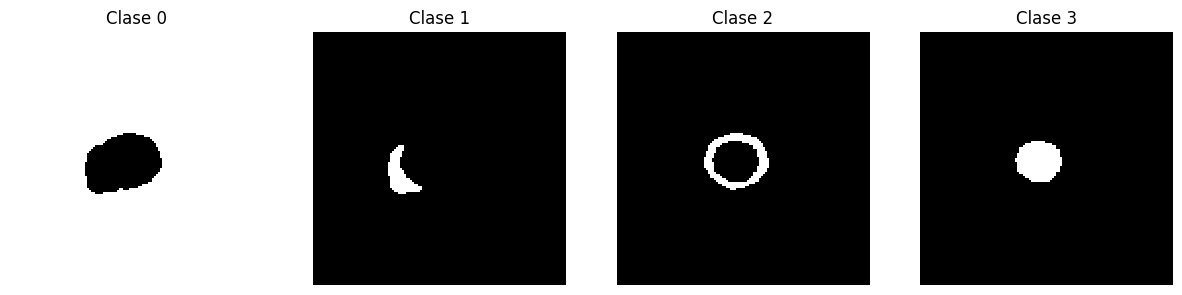

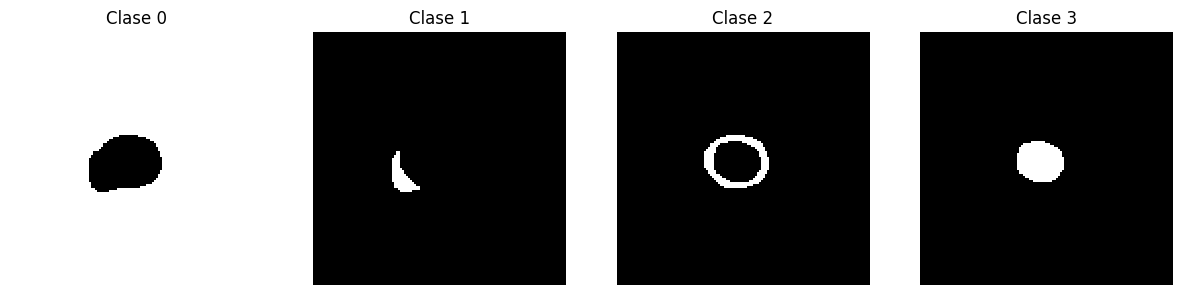

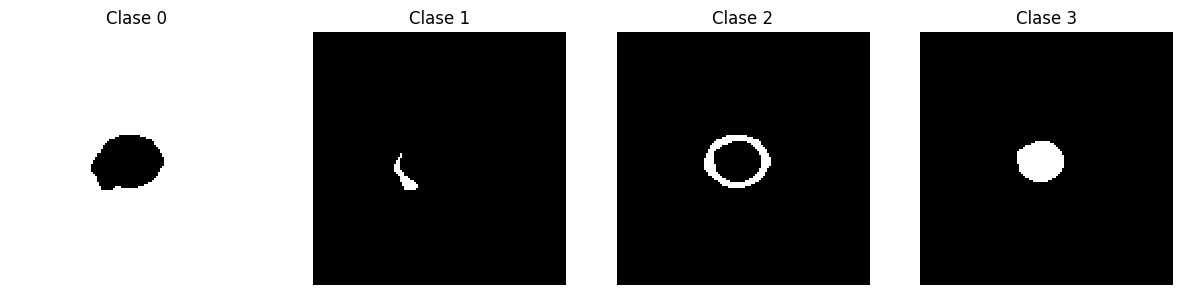

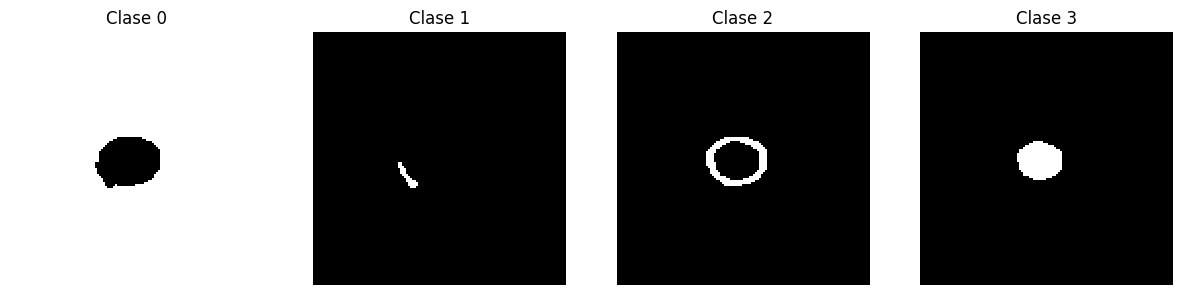

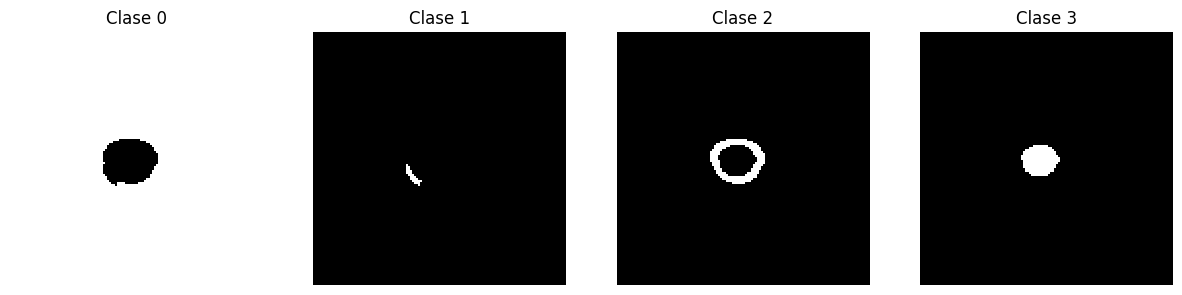

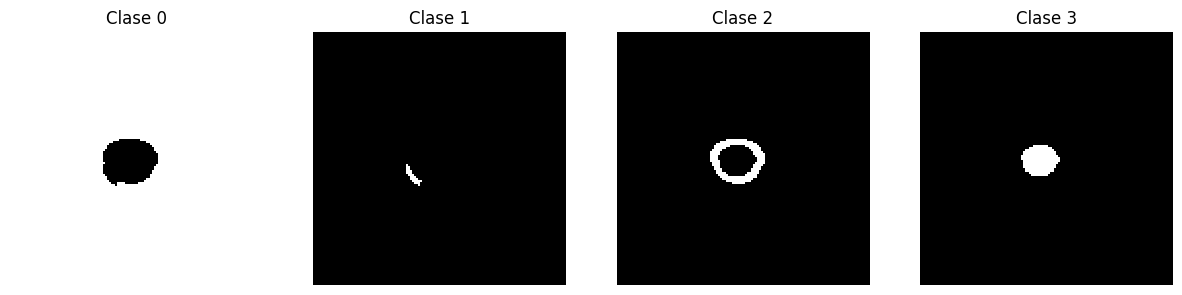

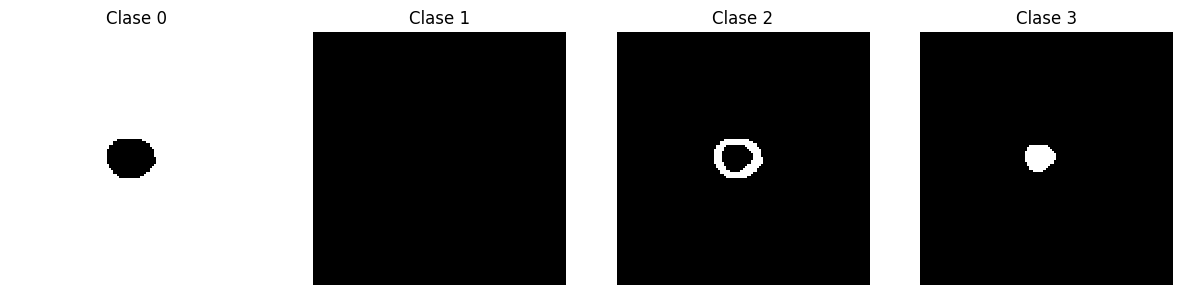

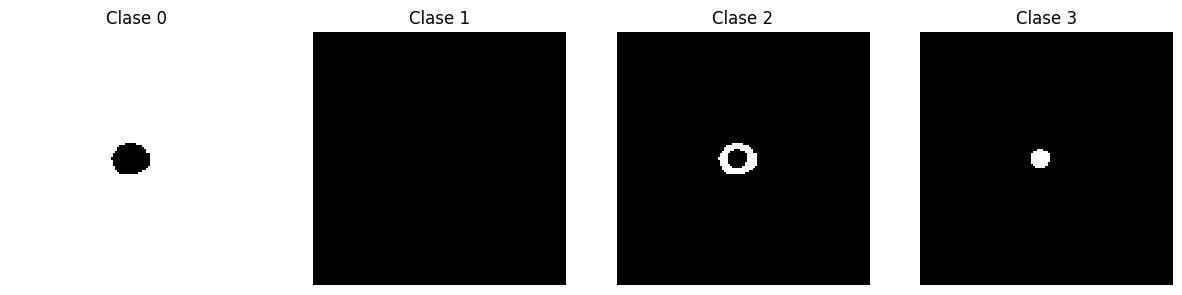

In [87]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

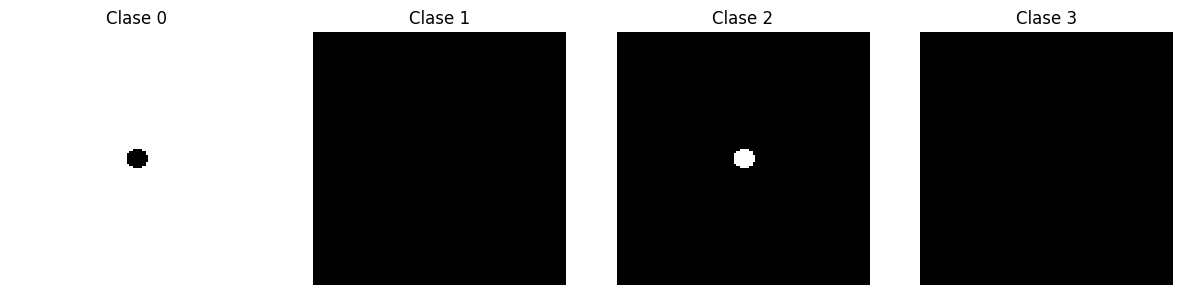

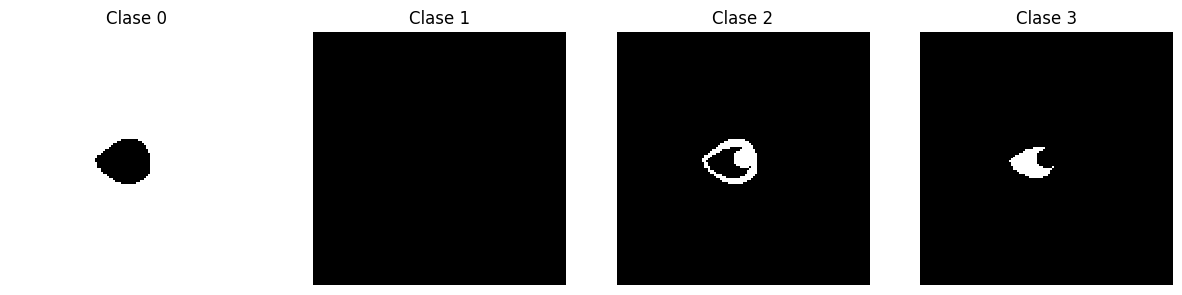

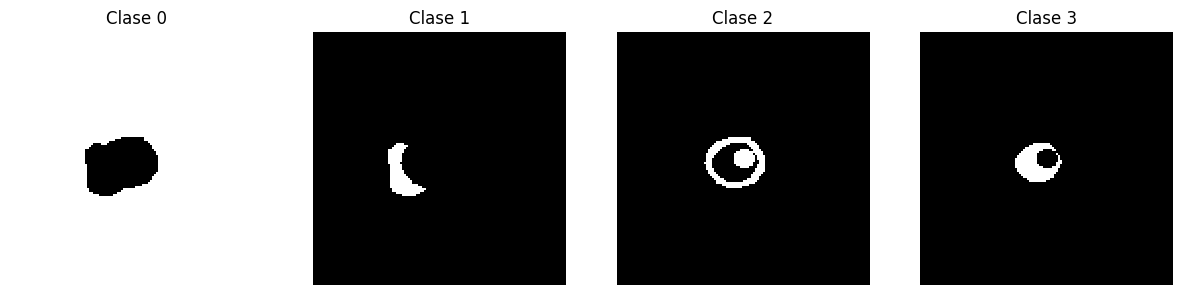

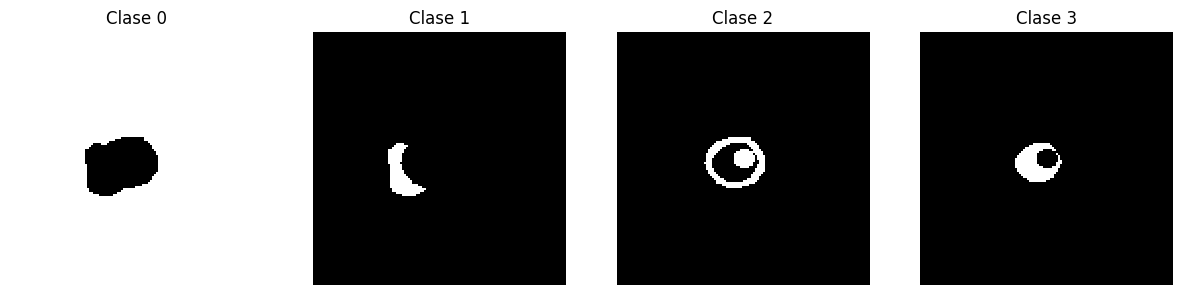

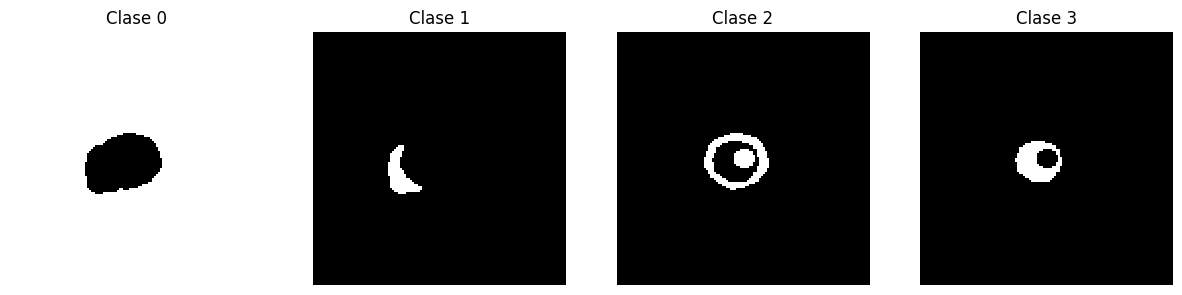

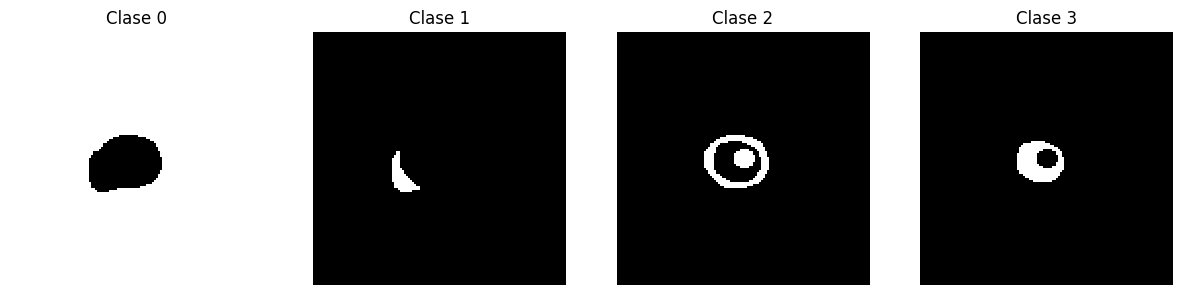

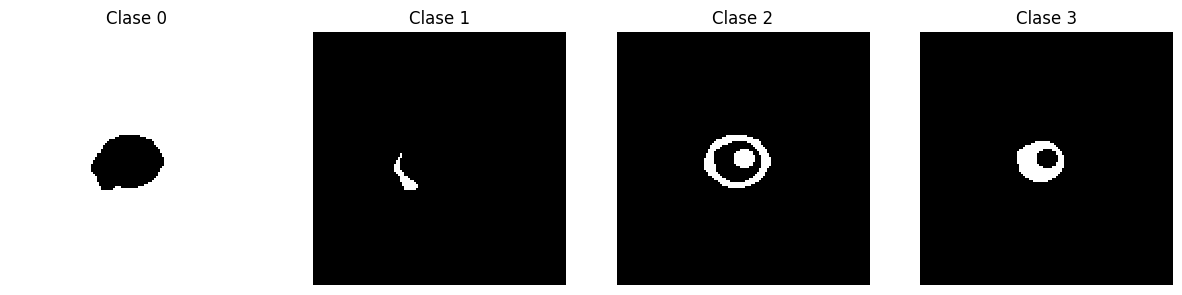

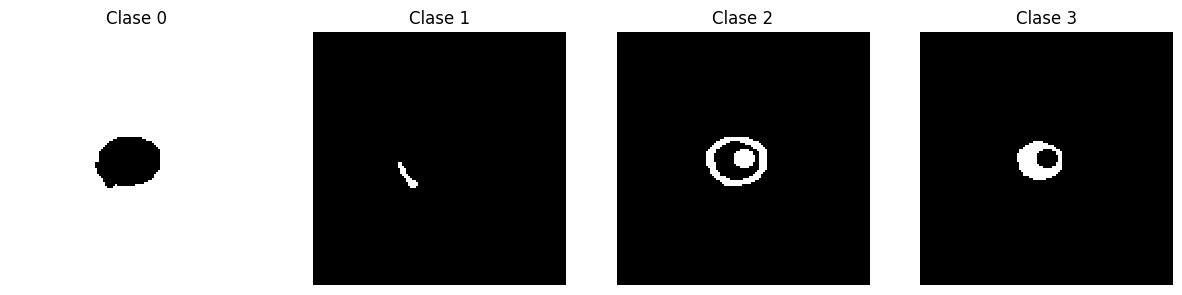

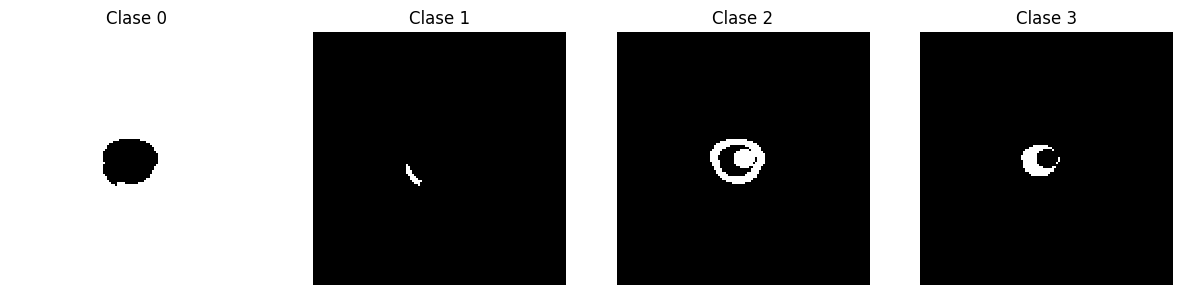

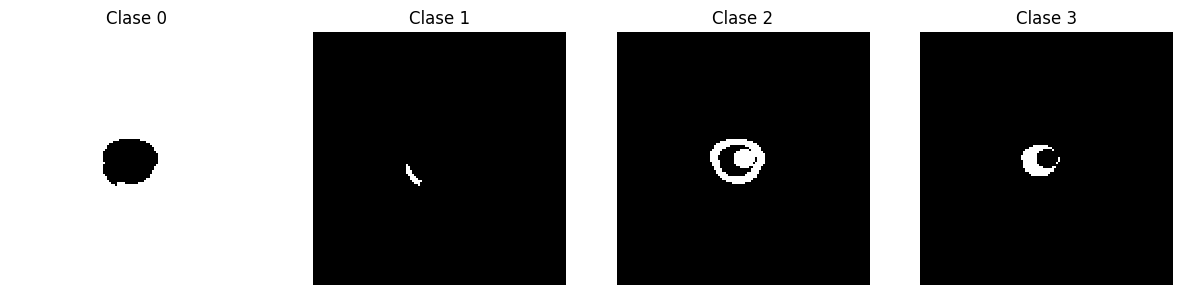

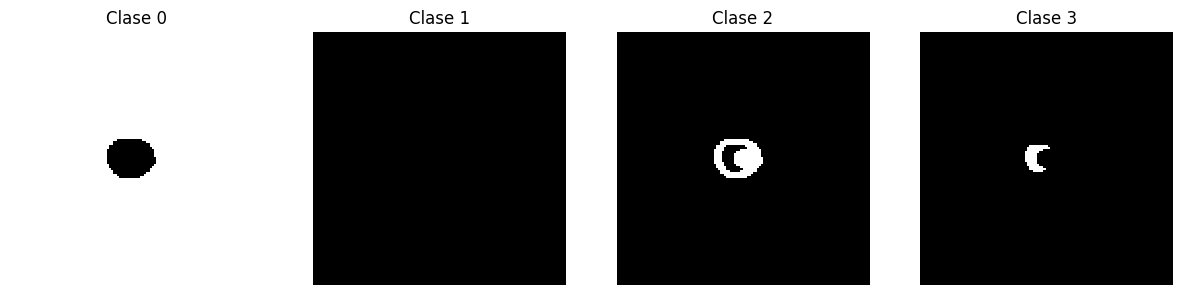

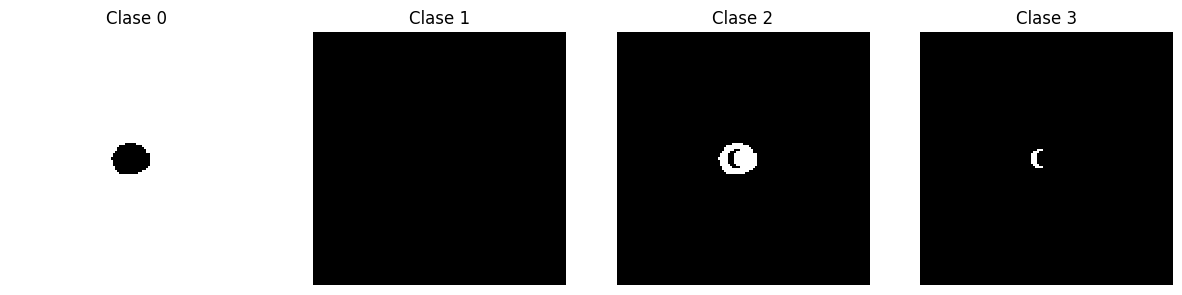

In [88]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts_noise)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

In [89]:
# Crear un Dataset de MONAI para los archivos de entrenamiento y validación

train_data_dicts = [{"image": file} for file in training_files]
train_ds = Dataset(data=train_data_dicts, transform=all_transforms)

val_data_dicts = [{"image": file} for file in testing_files]
val_ds = Dataset(data=val_data_dicts, transform=all_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds[0]["image"].shape}')
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds[0]["image"].shape}')

Image shape torch.Size([4, 12, 128, 128])
Image shape torch.Size([4, 12, 128, 128])


In [90]:
train_data_dicts_noise = [{"image": file} for file in training_files_noise]
train_ds_noise = Dataset(data=train_data_dicts_noise, transform=all_transforms)

val_data_dicts_noise = [{"image": file} for file in testing_files_noise]
val_ds_noise = Dataset(data=val_data_dicts_noise, transform=all_transforms)

train_loader_noise = DataLoader(train_ds_noise, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds_noise[0]["image"].shape}')
val_loader_noise = DataLoader(val_ds_noise, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds_noise[0]["image"].shape}')

Image shape torch.Size([4, 12, 128, 128])
Image shape torch.Size([4, 12, 128, 128])


In [91]:
train_data_dicts_elongated = [{"image": file} for file in training_files_elongated]
train_ds_elongated = Dataset(data=train_data_dicts_elongated, transform=all_transforms)

val_data_dicts_elongated = [{"image": file} for file in testing_files_elongated]
val_ds_elongated = Dataset(data=val_data_dicts_elongated, transform=all_transforms)

train_loader_elongated = DataLoader(train_ds_elongated, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds_elongated[0]["image"].shape}')
val_loader_elongated = DataLoader(val_ds_elongated, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds_elongated[0]["image"].shape}')

Image shape torch.Size([4, 12, 128, 128])
Image shape torch.Size([4, 12, 128, 128])


In [92]:
# Get one batch of validation data to visualize
first(val_loader).__getitem__("image").shape
first(val_loader_noise).__getitem__("image").shape
first(val_loader_elongated).__getitem__("image").shape

torch.Size([1, 4, 12, 128, 128])

In [93]:
postprocess_transform = transforms.AsDiscreted(keys="image", argmax=True, dim=0)
postprocess_mask = postprocess_transform(val_ds[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask.shape[0]):
    plt.subplot(1, postprocess_mask.shape[1], i + 1)
    plt.imshow(postprocess_mask[i], cmap="gray", interpolation='none')
    plt.axis("off")

In [94]:
postprocess_mask_noise = postprocess_transform(val_ds_noise[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask_noise.shape[0]):
    plt.subplot(1, postprocess_mask_noise.shape[1], i + 1)
    plt.imshow(postprocess_mask_noise[i], cmap="gray", interpolation='none')
    plt.axis("off")

In [95]:
postprocess_mask_elongated = postprocess_transform(val_ds_elongated[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask_elongated.shape[0]):
    plt.subplot(1, postprocess_mask_elongated.shape[1], i + 1)
    plt.imshow(postprocess_mask_elongated[i], cmap="gray", interpolation='none')
    plt.axis("off")

## Visualise examples from the training set

Imagen de entrenamiento cargada, tamaño: torch.Size([1, 4, 12, 128, 128])


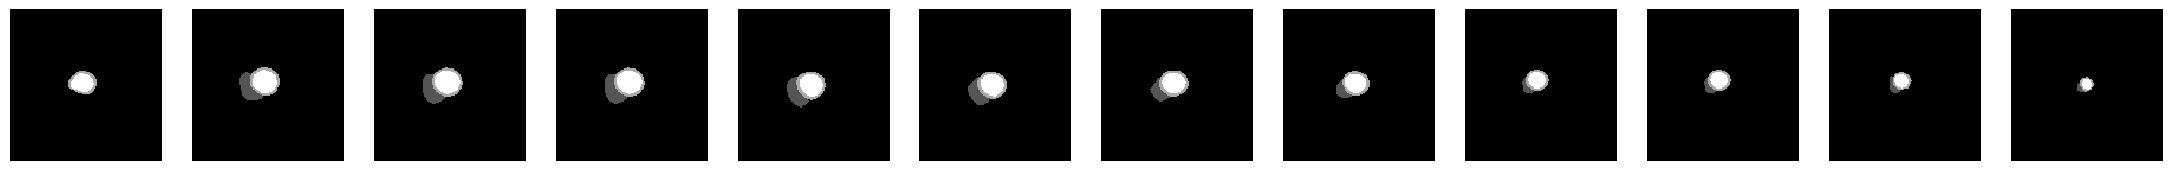

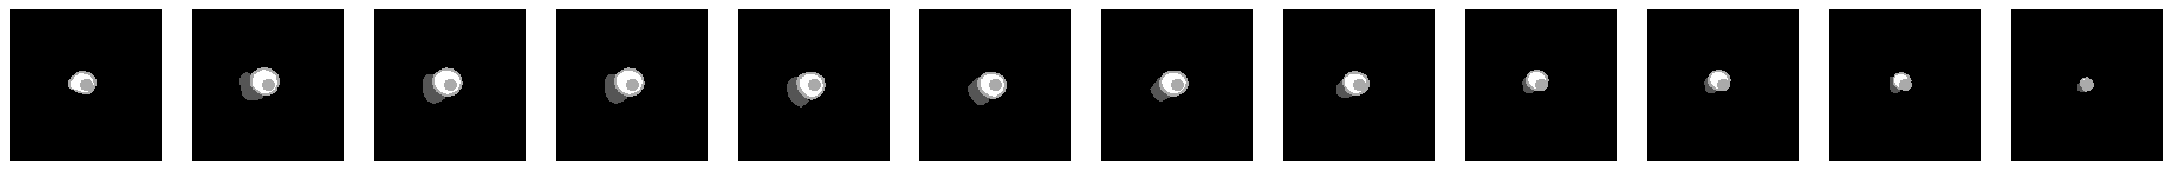

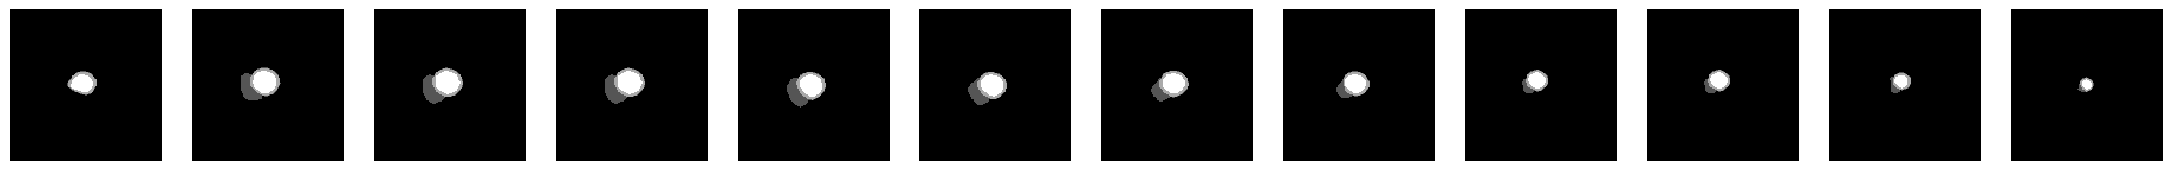

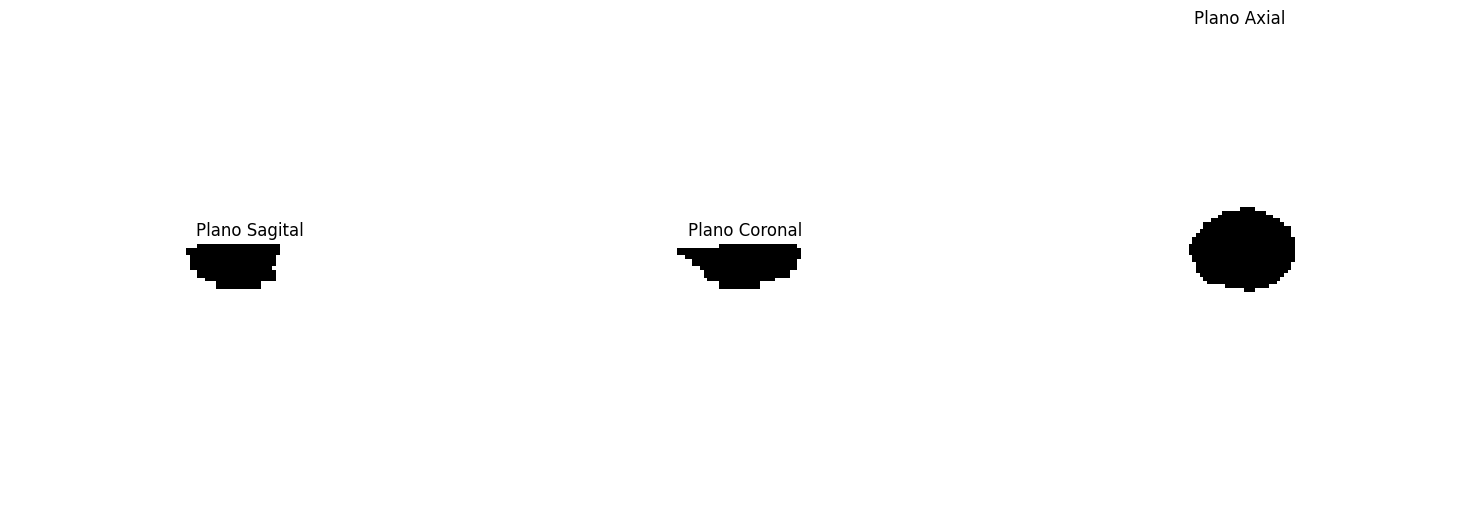

In [96]:
check_data = next(iter(train_loader))
image_tensor = check_data['image']  # Extrae la imagen como tensor

print(f"Imagen de entrenamiento cargada, tamaño: {image_tensor.shape}")


width_idx = image_tensor.size(4) // 2 # Sagittal
height_idx = image_tensor.size(3) // 2 # Coronal
depth_idx = image_tensor.size(2) // 2 # Axial

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plano sagital
image_slice_sagittal = image_tensor[0, 0, :, :, width_idx]
axs[0].imshow(image_slice_sagittal.cpu().numpy(), cmap='gray')
axs[0].set_title("Plano Sagital")
axs[0].axis('off')

# Plano coronal
image_slice_coronal = image_tensor[0, 0, :, height_idx, :]
axs[1].imshow(image_slice_coronal.cpu().numpy(), cmap='gray')
axs[1].set_title("Plano Coronal")
axs[1].axis('off')

# Plano axial
image_slice_axial = image_tensor[0, 0, depth_idx, :, :]
axs[2].imshow(image_slice_axial.cpu().numpy(), cmap='gray', interpolation='none')
axs[2].set_title("Plano Axial")
axs[2].axis('off')

plt.tight_layout()
plt.show()

Imagen de entrenamiento con ruido cargada, tamaño: torch.Size([1, 4, 12, 128, 128])


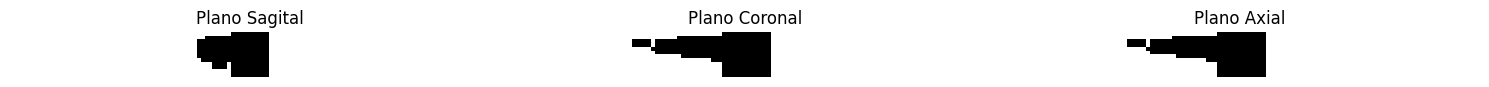

In [97]:
check_data_noise = next(iter(train_loader_noise))
image_tensor_noise = check_data_noise['image']  # Extrae la imagen como tensor

print(f"Imagen de entrenamiento con ruido cargada, tamaño: {image_tensor_noise.shape}")


width_idx = image_tensor_noise.size(4) // 2 # Sagittal
height_idx = image_tensor_noise.size(3) // 2 # Coronal
depth_idx = image_tensor_noise.size(2) // 2 # Axial

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plano sagital
image_slice_sagittal_noise = image_tensor_noise[0, 0, :, :, width_idx]
axs[0].imshow(image_slice_sagittal_noise.cpu().numpy(), cmap='gray')
axs[0].set_title("Plano Sagital")
axs[0].axis('off')

# Plano coronal
image_slice_coronal_noise = image_tensor_noise[0, 0, :, height_idx, :]
axs[1].imshow(image_slice_coronal_noise.cpu().numpy(), cmap='gray')
axs[1].set_title("Plano Coronal")
axs[1].axis('off')

# Plano axial
image_slice_axial_noise = image_tensor_noise[0, 0, depth_idx, :, :]
axs[2].imshow(image_slice_coronal_noise.cpu().numpy(), cmap='gray', interpolation='none')
axs[2].set_title("Plano Axial")
axs[2].axis('off')

plt.tight_layout()
plt.show()

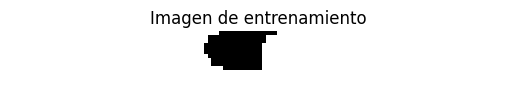

In [98]:
slice_idx = image_tensor.size(4) // 2
#image_slice = image_tensor[0, 0, :, :, slice_idx]
image_slice = image_tensor[0, :, :, :, slice_idx]

# Convertir el tensor en una imagen para visualizar con matplotlib
# plt.imshow(image_slice.cpu().numpy(), cmap='gray', interpolation='none')
plt.imshow(image_slice.permute(1, 2, 0).cpu().numpy(), interpolation='none')
plt.title("Imagen de entrenamiento")
plt.axis('off') 
plt.show()

Tamaño de la máscara cargada: torch.Size([1, 4, 12, 128, 128])
Representación one-hot generada correctamente. Visualizando cada voxel como un vector one-hot.


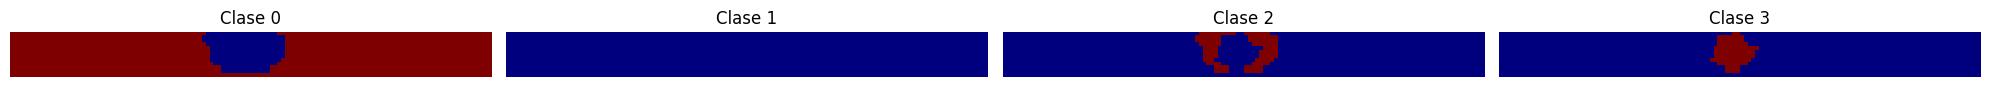

In [99]:
check_data = next(iter(train_loader)) 
image_tensor = check_data['image']

print(f"Tamaño de la máscara cargada: {image_tensor.shape}")

depth_idx = image_tensor.size(-1) // 2 
image_slice_axial = image_tensor[0, :, :, :, depth_idx]  # (batch, clases, ancho, alto, profundidad)

one_hot_representation = np.argmax(image_slice_axial.cpu().numpy(), axis=0)

print("Representación one-hot generada correctamente. Visualizando cada voxel como un vector one-hot.")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4): 
    axs[i].imshow((one_hot_representation == i).astype(int), cmap="jet", vmin=0, vmax=1, interpolation='none')
    axs[i].set_title(f"Clase {i}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()


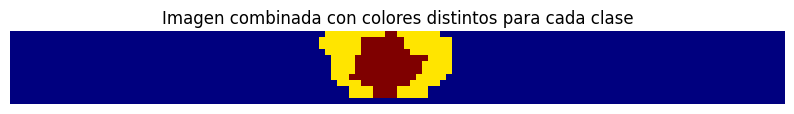

In [100]:
# slice axial del tensor de imagen
depth_idx = image_tensor.size(-1) // 2 
image_slice_axial = image_tensor[0, :, :, :, depth_idx]  # (batch, clases, ancho, alto, profundidad)

one_hot_representation = np.argmax(image_slice_axial.cpu().numpy(), axis=0)
combined_image = np.zeros_like(one_hot_representation, dtype=np.float32)

for i in range(4): 
    combined_image[one_hot_representation == i] = i / 3

plt.figure(figsize=(10, 8))
plt.imshow(combined_image, cmap="jet", vmin=0, vmax=1, interpolation='none')
plt.title("Imagen combinada con colores distintos para cada clase")
plt.axis("off")
plt.show()

## Define the network

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [35]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(

            # S1
            nn.Conv3d(4, 16, kernel_size=3, stride=(1,2,2), padding=1), # [4, 12, 128, 128] -> [16, 12, 64, 64]
            nn.BatchNorm3d(16),
            nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),

            #S2
            nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1),      # [16, 12, 64, 64] -> [32, 6, 32, 32]
            nn.BatchNorm3d(32),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),

            #S3
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),      # [32, 6, 32, 32] -> [64, 3, 16, 16]
            nn.BatchNorm3d(64),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),

            #S4
            nn.Conv3d(64, 1, kernel_size=3, stride=(1,2,2), padding=1),  # [64, 3, 16, 16] -> [1, 3, 8, 8]
            nn.BatchNorm3d(1),
            nn.ReLU(),
        )

        # Fully connected layer (Latent space)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 8 * 8, 64),
            nn.Linear(64, 3 * 8 * 8),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(

            #S4
            nn.ConvTranspose3d(1, 64, kernel_size=3, stride=(1,2,2), 
                               padding=1, output_padding=(0,1,1)),       # [1, 3, 8, 8] -> [64, 6, 16, 16]
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),

            #S3
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, 
                               padding=1, output_padding=1),            # [64, 3, 16, 16] -> [32, 6, 32, 32]
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),

            #S2
            nn.ConvTranspose3d(32, 16, kernel_size=3, stride=2, 
                               padding=1, output_padding=1),            # [32, 6, 32, 32] -> [16, 12, 64, 64]
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),

            #S1
            nn.ConvTranspose3d(16, 16, kernel_size=3, stride=(1,2,2), 
                               padding=1, output_padding=(0,1,1)),      # [16, 12, 64, 64] -> [16, 12, 128, 128]
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Conv3d(16, 4, kernel_size=3, padding=1),                 # [16, 12, 128, 128] -> [4, 12, 128, 128]
        )

    # def forward(self, x):
    #     encoded = self.encoder(x) # [4, 12, 128, 128] -> [1, 3, 8, 8]
    #     latent_vector = self.fc(encoded.view(encoded.size(0), -1)) # [batch_size, 64]
    #     decoded = self.decoder(latent_vector.view(encoded.size()))
    #     return decoded, latent_vector
    
    def forward(self, x):
        # Encoder
        encoded = self.encoder(x)  # [batch_size, 1, 3, 8, 8]
        flattened = encoded.view(encoded.size(0), -1)  # Aplanamos el tensor
        latent_vector = self.fc[1](flattened)  # Extraemos el vector latente: nn.Linear(3 * 8 * 8, 64)
        fc_output = self.fc[2:](latent_vector)  # Pasamos el vector latente por las capas restantes

        # Decoder
        reshaped = fc_output.view(encoded.size())  # Ajustamos a la forma necesaria para el decoder
        decoded = self.decoder(reshaped)

        return decoded, latent_vector  # Devolvemos la salida decodificada y el vector latente
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
sample_input = torch.randn(1, 4, 12, 128, 128).to(device) 
sample_output = model(sample_input)[0]
print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {sample_output.shape}")
print(model) 

Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Autoencoder(
  (encoder): Sequential(
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (6): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (8): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (11): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=Tru

In [37]:
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import f1_score

def dice_score(preds, targets, smooth=1e-6):
    preds = preds.argmax(dim=1).float()
    targets = targets.float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean().item()

model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6)
criterion = nn.CrossEntropyLoss()

# Entrenamiento
num_epochs = 20
val_interval = 1
train_loss_list = []
val_loss_list = []
best_val_dice = 0
best_train_latent_vectors = None
best_val_latent_vectors = None

# Entrenamiento
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    for batch_data in tqdm(train_loader):
        inputs = batch_data["image"].to(device)
        outputs, train_latent_vectors_output = model(inputs)
        
        loss = criterion(outputs, F.interpolate(inputs, size=outputs.shape[2:], mode='nearest'))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')
    
    # Validación
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        val_dice = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs = val_data["image"].to(device)
                val_outputs, val_latent_vectors_output = model(val_inputs)
                
                val_loss += criterion(val_outputs, F.interpolate(val_inputs, size=val_outputs.shape[2:], mode='nearest')).item()
                val_dice += dice_score(val_outputs, val_inputs)
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        val_loss_list.append(avg_val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Dice: {avg_val_dice:.4f}')
        
        # Guardar los vectores latentes si el Dice score es el mejor
        if avg_val_dice > best_val_dice:
            best_val_dice = avg_val_dice
            best_train_latent_vectors = []
            best_val_latent_vectors = []
            
            with torch.no_grad():
                for batch_data in tqdm(train_loader, desc="Saving Best Train Latent Vectors"):
                    inputs = batch_data["image"].to(device)
                    _, latent_vectors = model(inputs)
                    best_train_latent_vectors.append(latent_vectors.detach().cpu().numpy())

                for val_data in tqdm(val_loader, desc="Saving Best Validation Latent Vectors"):
                    val_inputs = val_data["image"].to(device)
                    _, latent_vectors = model(val_inputs)
                    best_val_latent_vectors.append(latent_vectors.detach().cpu().numpy())

if best_train_latent_vectors:
    best_train_latent_vectors = np.concatenate(best_train_latent_vectors, axis=0)
else:
    best_train_latent_vectors = np.array([])

if best_val_latent_vectors:
    best_val_latent_vectors = np.concatenate(best_val_latent_vectors, axis=0)
else:
    best_val_latent_vectors = np.array([])

last_train_latent_vectors = []
last_val_latent_vectors = []

model.eval()
with torch.no_grad():
    for batch_data in tqdm(train_loader, desc="Saving Train Latent Vectors"):
        inputs = batch_data["image"].to(device)
        _, latent_vectors = model(inputs)
        last_train_latent_vectors.append(latent_vectors.detach().cpu().numpy())

    for val_data in tqdm(val_loader, desc="Saving Validation Latent Vectors"):
        val_inputs = val_data["image"].to(device)
        _, latent_vectors = model(val_inputs)
        last_val_latent_vectors.append(latent_vectors.detach().cpu().numpy())

last_train_latent_vectors = np.concatenate(last_train_latent_vectors, axis=0)
last_val_latent_vectors = np.concatenate(last_val_latent_vectors, axis=0)

100%|██████████| 200/200 [00:11<00:00, 17.26it/s]


Epoch [1/20], Train Loss: 0.1444
Epoch [1/20], Validation Loss: 0.0975, Validation Dice: 0.0099


100%|██████████| 200/200 [00:11<00:00, 17.62it/s]


Epoch [2/20], Train Loss: 0.0807
Epoch [2/20], Validation Loss: 0.0852, Validation Dice: 0.0121


100%|██████████| 200/200 [00:11<00:00, 18.13it/s]


Epoch [3/20], Train Loss: 0.0723
Epoch [3/20], Validation Loss: 0.0777, Validation Dice: 0.0132


100%|██████████| 200/200 [00:11<00:00, 17.87it/s]


Epoch [4/20], Train Loss: 0.0670
Epoch [4/20], Validation Loss: 0.0747, Validation Dice: 0.0131


100%|██████████| 200/200 [00:11<00:00, 18.08it/s]


Epoch [5/20], Train Loss: 0.0634
Epoch [5/20], Validation Loss: 0.0748, Validation Dice: 0.0140


100%|██████████| 200/200 [00:11<00:00, 17.93it/s]


Epoch [6/20], Train Loss: 0.0620
Epoch [6/20], Validation Loss: 0.0673, Validation Dice: 0.0134


100%|██████████| 200/200 [00:09<00:00, 20.65it/s]


Epoch [7/20], Train Loss: 0.0561
Epoch [7/20], Validation Loss: 0.0709, Validation Dice: 0.0143


100%|██████████| 200/200 [00:11<00:00, 17.60it/s]


Epoch [8/20], Train Loss: 0.0509
Epoch [8/20], Validation Loss: 0.0674, Validation Dice: 0.0132


100%|██████████| 200/200 [00:11<00:00, 17.88it/s]


Epoch [9/20], Train Loss: 0.0491
Epoch [9/20], Validation Loss: 0.0632, Validation Dice: 0.0134


100%|██████████| 200/200 [00:11<00:00, 17.57it/s]


Epoch [10/20], Train Loss: 0.0454
Epoch [10/20], Validation Loss: 0.0615, Validation Dice: 0.0132


100%|██████████| 200/200 [00:11<00:00, 17.92it/s]


Epoch [11/20], Train Loss: 0.0455
Epoch [11/20], Validation Loss: 0.0626, Validation Dice: 0.0142


100%|██████████| 200/200 [00:10<00:00, 18.33it/s]


Epoch [12/20], Train Loss: 0.0453
Epoch [12/20], Validation Loss: 0.0564, Validation Dice: 0.0137


100%|██████████| 200/200 [00:09<00:00, 20.97it/s]


Epoch [13/20], Train Loss: 0.0414
Epoch [13/20], Validation Loss: 0.0566, Validation Dice: 0.0136


100%|██████████| 200/200 [00:10<00:00, 19.30it/s]


Epoch [14/20], Train Loss: 0.0395
Epoch [14/20], Validation Loss: 0.0577, Validation Dice: 0.0135


100%|██████████| 200/200 [00:09<00:00, 20.14it/s]


Epoch [15/20], Train Loss: 0.0407
Epoch [15/20], Validation Loss: 0.0590, Validation Dice: 0.0135


100%|██████████| 200/200 [00:10<00:00, 19.10it/s]


Epoch [16/20], Train Loss: 0.0401
Epoch [16/20], Validation Loss: 0.0603, Validation Dice: 0.0134


100%|██████████| 200/200 [00:11<00:00, 18.05it/s]


Epoch [17/20], Train Loss: 0.0374
Epoch [17/20], Validation Loss: 0.0542, Validation Dice: 0.0136


100%|██████████| 200/200 [00:10<00:00, 18.94it/s]


Epoch [18/20], Train Loss: 0.0385
Epoch [18/20], Validation Loss: 0.0534, Validation Dice: 0.0137


100%|██████████| 200/200 [00:10<00:00, 18.41it/s]


Epoch [19/20], Train Loss: 0.0385
Epoch [19/20], Validation Loss: 0.0553, Validation Dice: 0.0135


100%|██████████| 200/200 [00:10<00:00, 19.30it/s]


Epoch [20/20], Train Loss: 0.0363
Epoch [20/20], Validation Loss: 0.0553, Validation Dice: 0.0135


Saving Validation Latent Vectors: 100%|██████████| 100/100 [00:03<00:00, 25.07it/s]


In [38]:
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from tqdm import tqdm

# # Define MSE como métrica
# def mse_score(preds, targets):
#     return F.mse_loss(preds, targets, reduction="mean").item()

# # Inicialización del modelo y parámetros
# model = Autoencoder().to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6)
# criterion = nn.MSELoss()  # Cambia a MSE

# # Entrenamiento
# num_epochs = 20
# val_interval = 1
# train_loss_list = []
# val_loss_list = []
# best_val_mse = float('inf')  # MSE bajo es mejor
# best_train_latent_vectors = None
# best_val_latent_vectors = None

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
    
#     for batch_data in tqdm(train_loader):
#         inputs = batch_data["image"].to(device)
#         outputs, train_latent_vectors_output = model(inputs)
        
#         # Calcular pérdida con MSE
#         loss = criterion(outputs, F.interpolate(inputs, size=outputs.shape[2:], mode='nearest'))
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()

#     avg_train_loss = train_loss / len(train_loader)
#     train_loss_list.append(avg_train_loss)
#     print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')
    
#     # Validación
#     if (epoch + 1) % val_interval == 0:
#         model.eval()
#         val_loss = 0
#         val_mse = 0
#         with torch.no_grad():
#             for val_data in val_loader:
#                 val_inputs = val_data["image"].to(device)
#                 val_outputs, val_latent_vectors_output = model(val_inputs)
                
#                 val_loss += criterion(val_outputs, F.interpolate(val_inputs, size=val_outputs.shape[2:], mode='nearest')).item()
#                 val_mse += mse_score(val_outputs, F.interpolate(val_inputs, size=val_outputs.shape[2:], mode='nearest'))
        
#         avg_val_loss = val_loss / len(val_loader)
#         avg_val_mse = val_mse / len(val_loader)
#         val_loss_list.append(avg_val_loss)
#         print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation MSE: {avg_val_mse:.4f}')
        
#         if avg_val_mse < best_val_mse:  # MSE menor es mejor
#             best_val_mse = avg_val_mse
#             best_train_latent_vectors = []
#             best_val_latent_vectors = []
            
#             with torch.no_grad():
#                 for batch_data in tqdm(train_loader, desc="Saving Best Train Latent Vectors"):
#                     inputs = batch_data["image"].to(device)
#                     _, latent_vectors = model(inputs)
#                     best_train_latent_vectors.append(latent_vectors.detach().cpu().numpy())

#                 for val_data in tqdm(val_loader, desc="Saving Best Validation Latent Vectors"):
#                     val_inputs = val_data["image"].to(device)
#                     _, latent_vectors = model(val_inputs)
#                     best_val_latent_vectors.append(latent_vectors.detach().cpu().numpy())

# if best_train_latent_vectors:
#     best_train_latent_vectors = np.concatenate(best_train_latent_vectors, axis=0)
# else:
#     best_train_latent_vectors = np.array([])

# if best_val_latent_vectors:
#     best_val_latent_vectors = np.concatenate(best_val_latent_vectors, axis=0)
# else:
#     best_val_latent_vectors = np.array([])

# last_train_latent_vectors = []
# last_val_latent_vectors = []

# model.eval()
# with torch.no_grad():
#     for batch_data in tqdm(train_loader, desc="Saving Train Latent Vectors"):
#         inputs = batch_data["image"].to(device)
#         _, latent_vectors = model(inputs)
#         last_train_latent_vectors.append(latent_vectors.detach().cpu().numpy())

#     for val_data in tqdm(val_loader, desc="Saving Validation Latent Vectors"):
#         val_inputs = val_data["image"].to(device)
#         _, latent_vectors = model(val_inputs)
#         last_val_latent_vectors.append(latent_vectors.detach().cpu().numpy())

# last_train_latent_vectors = np.concatenate(last_train_latent_vectors, axis=0)
# last_val_latent_vectors = np.concatenate(last_val_latent_vectors, axis=0)

In [73]:
print(f"Train Latent Vector Shape (last epoch): {last_train_latent_vectors.shape}")
print(f"Train Latent Vector Shape (best epoch): {best_train_latent_vectors.shape}")
print(f"Validation Latent Vector Shape (last epoch): {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape (best epoch): {best_val_latent_vectors.shape}")
print(last_train_latent_vectors[0].shape)
print(last_val_latent_vectors[0].shape)
print(best_train_latent_vectors[0].shape)
print(best_val_latent_vectors[0].shape)

Train Latent Vector Shape (last epoch): (200, 64)
Train Latent Vector Shape (best epoch): (200, 64)
Validation Latent Vector Shape (last epoch): (100, 64)
Validation Latent Vector Shape (best epoch): (100, 64)
(64,)
(64,)
(64,)
(64,)


In [73]:
# # Guardar los vectores latentes de la mejor época
# output_dir = '/mnt/nfs/home/liglesias'
# np.savetxt(os.path.join(output_dir, 'best_train_latent_vectors.tsv'), best_train_latent_vectors, delimiter='\t')
# np.savetxt(os.path.join(output_dir, 'best_val_latent_vectors.tsv'), best_val_latent_vectors, delimiter='\t')

# print(f"Vectores latentes de la mejor época guardados en {output_dir}")

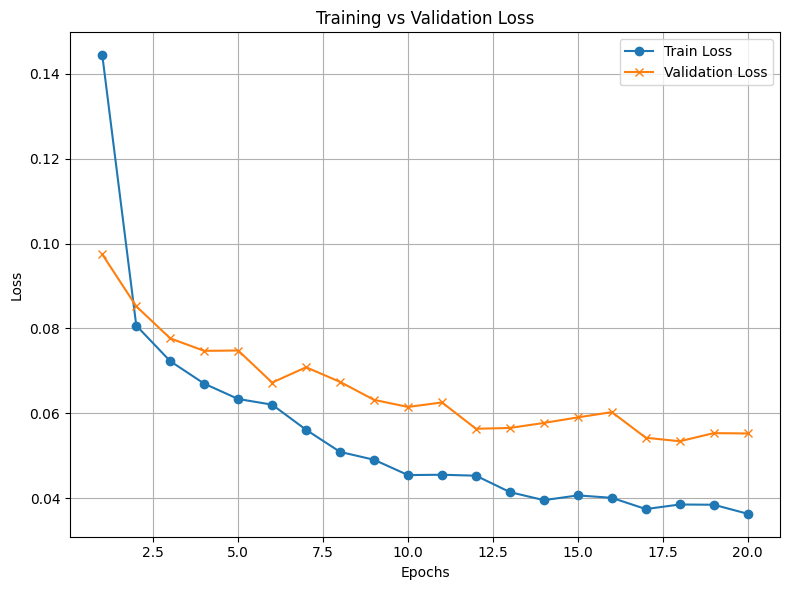

In [40]:
# Visualización de pérdidas
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_loss_list, label="Train Loss", marker='o')
val_epochs = list(range(val_interval, num_epochs + 1, val_interval))
plt.plot(val_epochs, val_loss_list, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
def visualize_axial_reconstruction(model, data_loader, device):
    postprocess_transform = transforms.AsDiscreted(keys="image", argmax=True, dim=1)

    model.eval()
    with torch.no_grad():
        batch_data = next(iter(data_loader))
        inputs = batch_data["image"].to(device)

        print(f"Min: {inputs.min()}, Max: {inputs.max()}, Mean: {inputs.mean()}, Std: {inputs.std()}")
        outputs, _ = model(inputs)

        postprocess_input = postprocess_transform({"image": inputs})["image"]
        postprocess_output = postprocess_transform({"image": outputs})["image"]

        print(f"Input shape: {inputs.shape}")
        print(f"Output shape: {outputs.shape}")
        print(f"Postprocess output shape: {postprocess_output.shape}")

        slice_idx = postprocess_output.shape[2] // 2  # Índice de la rebanada central
        
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(postprocess_input[0, 0, slice_idx].cpu().numpy(), cmap="gray", interpolation='none')
        plt.title("Imagen Original")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(postprocess_output[0, 0, slice_idx].cpu().numpy(), cmap="gray", interpolation='none')
        plt.title("Reconstrucción")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])


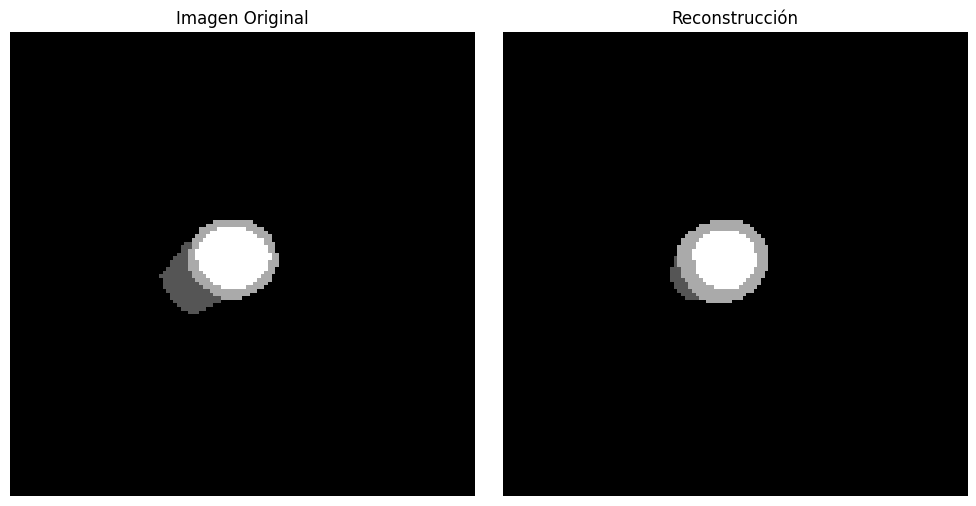

In [42]:
visualize_axial_reconstruction(model, val_loader, device)

In [43]:
torch.save(model.state_dict(), 'autoencoder_model.pth')

In [101]:
train_latent_vectors_noise = []
val_latent_vectors_noise = []

with torch.no_grad():
    for batch_data in tqdm(train_loader_noise, desc="Encoding Noisy Train Images"):
        noisy_inputs = batch_data["image"].to(device) 
    
        encoded = model.encoder(noisy_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        train_latent_vectors_noise.append(latent_vector.cpu().numpy())  

with torch.no_grad():
    for batch_data in tqdm(val_loader_noise, desc="Encoding Noisy Validation Images"):
        noisy_inputs = batch_data["image"].to(device) 
        
        encoded = model.encoder(noisy_inputs) 

        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        val_latent_vectors_noise.append(latent_vector.cpu().numpy())  
        
train_latent_vectors_noise = np.concatenate(train_latent_vectors_noise, axis=0)
val_latent_vectors_noise = np.concatenate(val_latent_vectors_noise, axis=0)  

print(f"Train Latent Vectors Shape (Noise): {train_latent_vectors_noise.shape}")
print(f"Validation Latent Vectors Shape (Noise): {val_latent_vectors_noise.shape}")
# print(f"Validation Latent Vectors (Noise): {val_latent_vectors_noise[0]}")

Encoding Noisy Validation Images: 100%|██████████| 100/100 [00:04<00:00, 24.95it/s]

Train Latent Vectors Shape (Noise): (200, 64)
Validation Latent Vectors Shape (Noise): (100, 64)


In [102]:
train_latent_vectors_elongated = []
val_latent_vectors_elongated = []

with torch.no_grad():
    for batch_data in tqdm(train_loader_elongated, desc="Encoding Elongated Train Images"):
        elongated_inputs = batch_data["image"].to(device) 
    
        encoded = model.encoder(elongated_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        train_latent_vectors_elongated.append(latent_vector.cpu().numpy())  

with torch.no_grad():
    for batch_data in tqdm(val_loader_elongated, desc="Encoding Elongated Validation Images"):
        elongated_inputs = batch_data["image"].to(device) 
        
        encoded = model.encoder(elongated_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        val_latent_vectors_elongated.append(latent_vector.cpu().numpy())  
        
train_latent_vectors_elongated = np.concatenate(train_latent_vectors_elongated, axis=0)
val_latent_vectors_elongated = np.concatenate(val_latent_vectors_elongated, axis=0)  

print(f"Train Latent Vectors Shape (Elongation): {train_latent_vectors_elongated.shape}")
print(f"Validation Latent Vectors Shape (Elongation): {val_latent_vectors_elongated.shape}")
# print(f"Validation Latent Vectors (Elongation): {val_latent_vectors_noise[0]}")

Encoding Elongated Validation Images: 100%|██████████| 100/100 [00:04<00:00, 23.61it/s]

Train Latent Vectors Shape (Elongation): (200, 64)
Validation Latent Vectors Shape (Elongation): (100, 64)


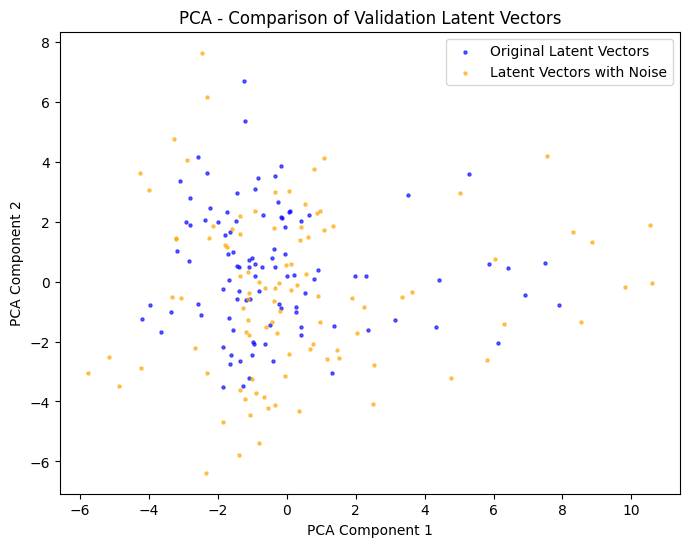

In [103]:
from sklearn.decomposition import PCA
# all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_noise], axis=0)
all_val_latent_vectors = np.concatenate([best_val_latent_vectors, val_latent_vectors_noise], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)
all_val_latent_vectors_pca.shape

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_pca[100:, 0], all_val_latent_vectors_pca[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('PCA - Comparison of Validation Latent Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

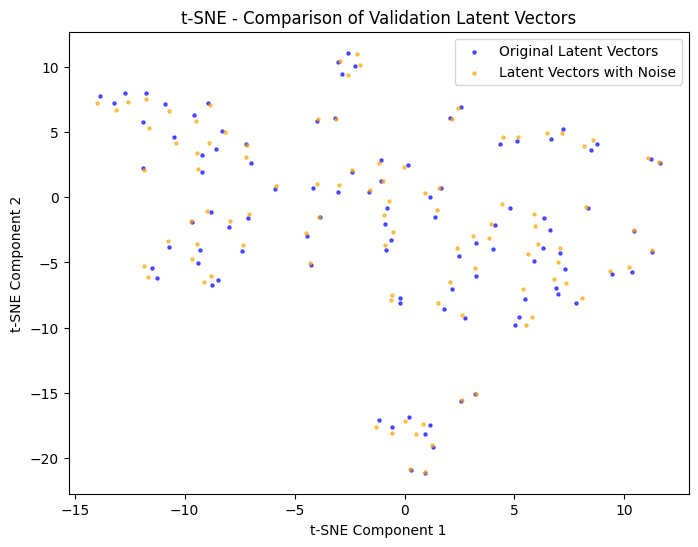

In [104]:
# Usando t-sne en lugar de PCA
from sklearn.manifold import TSNE
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors, val_latent_vectors_noise], axis=0)

tsne = TSNE(n_components=2, random_state=42)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_tsne[:100, 0], all_val_latent_vectors_tsne[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_tsne[100:, 0], all_val_latent_vectors_tsne[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('t-SNE - Comparison of Validation Latent Vectors')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


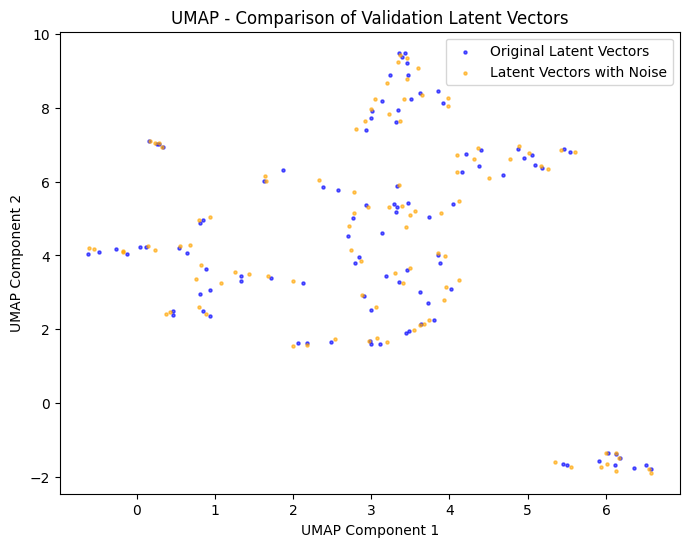

In [105]:
# Usando UMAP
import umap
all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_noise], axis=0)
#all_val_latent_vectors = np.concatenate([best_val_latent_vectors, val_latent_vectors_noise], axis=0)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_umap[:100, 0], all_val_latent_vectors_umap[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_umap[100:, 0], all_val_latent_vectors_umap[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('UMAP - Comparison of Validation Latent Vectors')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

EUCLIDEAN DISTANCE

In [106]:
# Euclidean distances between the latent vectors of the last epoch and the latent vectors with noise

print(f"Validation Latent Vector Shape: {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_noise.shape}")

print(last_val_latent_vectors[0].shape)
print(val_latent_vectors_noise[0].shape)

assert last_val_latent_vectors.shape == val_latent_vectors_noise.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_noise, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.8970601  0.6736441  0.74651563 0.26468632 0.66736954 0.11535934
 0.9121702  0.20929945 0.64302874 0.07356503 0.9268623  0.93064725
 0.94489324 0.74963456 0.65069884 0.93827075 1.8428301  1.8883611
 0.58993715 0.7983657  0.5132547  0.3043173  0.9762633  1.0257399
 1.378976   1.3991339  0.75401527 0.12058018 0.5995572  0.13783143
 0.741271   1.0252419  0.74597573 0.29991305 0.7995309  0.31980526
 1.3035222  1.0682586  0.20652007 0.16805975 1.277405   0.83957475
 0.568702   0.6384061  0.8548277  1.0537437  1.0206121  1.5803292
 1.5012479  1.0727798  1.0546048  0.4763648  1.2043344  1.7193644
 0.7449111  0.9795895  1.3809588  0.796444   0.6053603  0.17765197
 0.95542216 0.9557428  0.8901477  0.88989407 0.7386363  0.5988752
 0.621279   0.5614946  0.6300507  0.3958622  0.44493958 0.12969823
 0.5005455  0.7875416  0.9017027  0.41797146 0.87104976 1.3483124
 1.127181

In [108]:
# Euclidean distance between the latent vectors of the last epoch and the latent vectors with elongation

print(f"Validation Latent Vector Shape: {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_elongated.shape}")

print(last_val_latent_vectors[0].shape)
print(val_latent_vectors_elongated[0].shape)

assert last_val_latent_vectors.shape == val_latent_vectors_elongated.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.23360974 0.21405059 0.20322181 0.1327198  0.25385922 0.27810276
 0.27668676 0.209862   0.23864545 0.17264757 0.19226721 0.20919277
 0.2786671  0.21296138 0.24930997 0.17666307 0.34961668 0.31647867
 0.25387102 0.21499233 0.26458186 0.19706139 0.3056993  0.34182733
 0.37797338 0.3356546  0.24693106 0.21928138 0.31548166 0.27277195
 0.34356937 0.25242624 0.3922089  0.46067077 0.2917847  0.31119472
 0.28066304 0.26965356 0.28136882 0.23166081 0.32537752 0.25579867
 0.35975018 0.3295366  0.43350285 0.28978375 0.34140834 0.33389512
 0.26466647 0.1913959  0.21962453 0.2130341  0.3882352  0.4337743
 0.41617936 0.34721556 0.30941847 0.2696121  0.2998742  0.30265597
 0.3308902  0.3102923  0.331751   0.34828407 0.26698673 0.26291186
 0.1980577  0.17277841 0.20839037 0.20445529 0.37928942 0.35025945
 0.24959853 0.21913421 0.18012874 0.1572327  0.45248973 0.40438408
 0.2

In [109]:
# Euclidean distance

# Distancias euclidianas entre los vectores latentes de la época con mejor Dice y los vectores latentes con ruido

print(f"Validation Latent Vector Shape: {best_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_noise.shape}")

print(best_val_latent_vectors[0].shape)
print(val_latent_vectors_noise[0].shape)

assert best_val_latent_vectors.shape == val_latent_vectors_noise.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors - val_latent_vectors_noise, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [3.007424  3.2239234 3.5158734 3.5735655 3.628287  3.8351789 3.336515
 3.021778  3.104981  3.1215518 3.6960385 3.6784194 3.1195796 3.0331037
 3.6924624 3.4746668 6.033516  5.160618  3.4401174 3.2301872 3.3647797
 3.1031668 5.9022017 5.3949575 4.0245295 3.7034492 4.003421  3.6451368
 3.6200955 3.3896806 3.5274231 3.3783906 6.0340986 5.6324406 3.0846121
 3.0924122 3.1582217 3.264907  3.5382643 3.290602  3.6495671 3.1269412
 3.8318741 3.4281726 3.8893883 3.695931  4.0235276 4.08316   3.6316187
 3.1790462 3.1786213 3.2591918 5.0475082 4.490308  4.303842  3.7167134
 3.4389246 3.3414676 3.7429147 3.4087856 4.449816  4.258012  3.1493044
 3.1076186 4.9349723 4.7253294 3.4638393 3.5959866 3.4217556 3.3811877
 3.8130248 3.758429  5.9910975 5.4741735 3.4260097 3.250361  6.187165
 5.322223  3.6032493 3.2832658 3.0662653 3.1686335 3.318727  3.726453
 3.845611  4.0049644 2.82

In [110]:
# Euclidean distance

# Distancias euclidianas entre los vectores latentes de la época con mejor Dice y los vectores latentes con elongación

print(f"Validation Latent Vector Shape: {best_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_elongated.shape}")

print(best_val_latent_vectors[0].shape)
print(val_latent_vectors_elongated[0].shape)

assert best_val_latent_vectors.shape == val_latent_vectors_elongated.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors - val_latent_vectors_elongated, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [3.1543005 3.3316312 3.5687869 3.5910194 3.6221597 3.8592331 3.350792
 3.0658174 3.120534  3.1510804 3.8200576 3.7637265 3.3833554 3.1490602
 3.657496  3.540156  5.873798  4.9356437 3.4423134 3.2740562 3.341625
 3.1999373 5.7218537 5.3100266 4.1069164 3.7995517 3.9659395 3.7222617
 3.5855827 3.3958008 3.5144243 3.4271998 6.0497966 5.586087  3.1273155
 3.0748515 3.2014828 3.2225046 3.6443841 3.396958  3.791318  3.1385608
 3.7471464 3.418677  3.7081409 3.688321  3.682063  3.6072664 3.8155367
 3.2517052 3.2137778 3.2293353 4.820757  4.1799774 4.148819  3.6748686
 3.6814675 3.3669508 3.6634226 3.3560743 4.5298715 4.3407264 3.1829422
 3.1187422 4.924934  4.710579  3.496189  3.5760255 3.455414  3.4199266
 3.7502522 3.6494765 6.0230317 5.582819  3.3686922 3.2084148 6.1710443
 5.375167  3.6723197 3.2669265 3.1363816 3.1376052 3.3387063 3.7132468
 3.773696  3.8548472 3.0

In [82]:
train_latent_vectors_array = np.concatenate((last_train_latent_vectors,train_latent_vectors_noise), axis=0)
val_latent_vectors_array = np.concatenate((last_val_latent_vectors, val_latent_vectors_noise), axis=0)

print(f"Shape of train_latent_vectors_array: {train_latent_vectors_array.shape}")
print(f"Shape of val_latent_vectors_array: {val_latent_vectors_array.shape}")

if len(train_latent_vectors_array.shape) == 1:
    train_latent_vectors_array = train_latent_vectors_array.reshape(-1, 1)
if len(val_latent_vectors_array.shape) == 1:
    val_latent_vectors_array = val_latent_vectors_array.reshape(-1, 1)

output_dir = '/mnt/nfs/home/liglesias'
np.savetxt(os.path.join(output_dir, 'train_latent_vectors.tsv'), train_latent_vectors_array, delimiter='\t')
np.savetxt(os.path.join(output_dir, 'val_latent_vectors.tsv'), val_latent_vectors_array, delimiter='\t')

print(f"Vectores latentes guardados en {output_dir}")

Shape of train_latent_vectors_array: (400, 64)
Shape of val_latent_vectors_array: (200, 64)
Vectores latentes guardados en /mnt/nfs/home/liglesias


In [83]:
import os
import pandas as pd

output_dir = '/mnt/nfs/home/liglesias'
val_latent_vectors_df = pd.read_csv(os.path.join(output_dir, 'val_latent_vectors.tsv'), sep='\t', header=None)
print(f"Shape of val_latent_vectors_df: {val_latent_vectors_df.shape}")

val_latent_vectors_original_df = val_latent_vectors_df.iloc[:100]
val_latent_vectors_noise_df = val_latent_vectors_df.iloc[-100:]

num_original = len(val_latent_vectors_original_df)
num_noise = len(val_latent_vectors_noise_df)

metadata = {
    'ID': list(range(1, num_original + num_noise + 1)),
    'Type': ['Original'] * num_original + ['Noise'] * num_noise
}
metadata_df = pd.DataFrame(metadata)

metadata_df.to_csv(os.path.join(output_dir, 'metadata.tsv'), sep='\t', index=False)

print(f"Archivo de metadatos guardado en {output_dir}/metadata.tsv")

Shape of val_latent_vectors_df: (200, 64)
Archivo de metadatos guardado en /mnt/nfs/home/liglesias/metadata.tsv
